# A lightweight, fully-distributed AI framework for energy-efficient resource allocation in LoRa networks

In [2]:
import gym
from gym import spaces
import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.ticker
import numpy as np
import math
import datetime as dt
import wandb
%load_ext line_profiler

In [3]:
#path = "/content/drive/MyDrive/Colab Data/"
path = "data/"
folder="test7"

In [4]:
#LoRa settings
Ptx = 14
gamma = 2.08
d0 = 40.0
var = 0
Lpld0 = 127.41
GL = 0

sf7 = np.array([7,-123,-120,-116])
sf8 = np.array([8,-126,-123,-119])
sf9 = np.array([9,-129,-125,-122])
sf10 = np.array([10,-132,-128,-125])
sf11 = np.array([11,-134.5,-130,-128])
sf12 = np.array([12,-137,-133,-130])
sensi = np.array([sf7,sf8,sf9,sf10,sf11,sf12])
minsensi = -112.0
Lpl = Ptx - minsensi

maxX=500;
maxY=500;

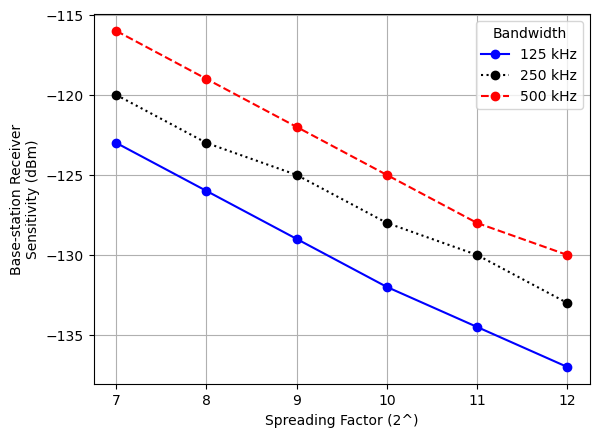

[[137.  134.  130. ]
 [140.  137.  133. ]
 [143.  139.  136. ]
 [146.  142.  139. ]
 [148.5 144.  142. ]
 [151.  147.  144. ]]
[[ 63.43001337  54.9105983   45.30415204]
 [ 73.27122124  63.43001337  52.33312073]
 [ 84.63929891  69.83190469  60.45263848]
 [ 97.77114124  80.66637016  69.83190469]
 [110.25785531  88.80789982  80.66637016]
 [124.33929383 102.58650329  88.80789982]]
63.43001336951186


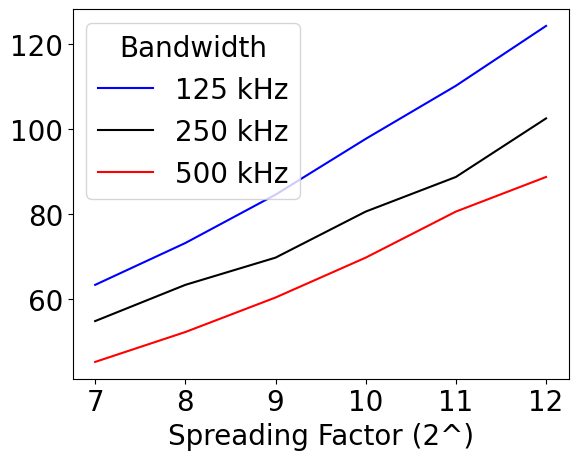

63.43001336951186


In [5]:
# plotting
def plotSensitivity(sensi):
    sensi_fig = plt.figure()

    s125, = plt.plot(sensi[:,0], sensi[:,1],"bo-", label="125 kHz")
    s250, = plt.plot(sensi[:,0], sensi[:,2],"ko:", label="250 kHz")
    s500, = plt.plot(sensi[:,0], sensi[:,3],"ro--", label="500 kHz")
    #print(sensi[:,1])

    plt.legend(title="Bandwidth", handles = [s125, s250, s500])
    plt.grid()
    plt.xlabel("Spreading Factor (2^)")
    plt.ylabel("Base-station Receiver\nSensitivity (dBm)")
    plt.xticks([7,8,9,10,11,12])

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 20
    plt.show()

plotSensitivity(sensi)

# node placement
Lpl_matrix = Ptx - (sensi[:,1:])
print(Lpl_matrix)
maxDist = np.dot(d0, np.exp(np.divide((Lpl_matrix - Lpld0),(10*gamma))))
print(maxDist)
print(d0*(math.e**((Lpl_matrix[0,0]-Lpld0)/(10.0*gamma))))
bestDist = np.amin(maxDist)
bestDist = np.max(maxDist[:,0])
minDist = np.amin(maxDist[:,0])

def plotMaxDistFig():
    maxDist_fig = plt.figure()
    s125, = plt.plot(sensi[:,0], maxDist[:,0], 'b', label="125 kHz")
    s250, = plt.plot(sensi[:,0], maxDist[:,1], 'k', label="250 kHz")
    s500, = plt.plot(sensi[:,0], maxDist[:,2], 'r', label="500 kHz")
    plt.legend(title="Bandwidth", handles = [s125, s250, s500])
    plt.xticks([7,8,9,10,11,12])
    plt.xlabel("Spreading Factor (2^)")
    plt.show()

plotMaxDistFig()

print(minDist)

In [6]:
#
# this function creates a BS
#
class myBS:
    def __init__(self, id, position):
        self.id = id
        self.x, self.y = position
        self.packet = [];

#
# this function creates a node
#
class myNode:
    def __init__(self, id, position = (1,1), period = 20000):
        self.id = id
        self.x, self.y = position
        self.period = period
        self.dist = []
        self.freq = 868.3
        self.packetlen = 50
        self.packet = [];
        self.bw = 125
        self.sf = 12
        self.cr = 1
        self.sent = 0
        self.delivered = 0
        self.total_airtime = 0

    def getTransmissionParams(self):
        # this function currently returns fixed parameters

        return self.freq, self.bw, self.sf, self.cr

    def updateSF(self, sf):
      self.sf = sf

    def updatePos(self, position):
      self.x, self.y = position

    def updateDist(self, bsList):
      self.dist = []
      for b in bsList:
        d = math.sqrt((self.x-b.x)*(self.x-b.x)+(self.y-b.y)*(self.y-b.y))
        self.dist.append(d)
        #magicPacket=myPacket(self.id, self.packetlen, d, self.freq, b.id, self.sf, self.cr, self.bw)
        #b.packet.append(magicPacket)
        #self.packet.append(magicPacket)


#
# this function creates a packet (associated with a node)
# it also sets all parameters, currently random
#
class myPacket:

    def toString(self):
      return "Packet - Node:" + str(self.node) + " BS: " + str(self.bs) + " SF: " + str(self.sf)

    def __init__(self, node, plen, distance, freq, bs, sf, cr, bw):
        global Ptx
        global gamma
        global d0
        global Lpld0
        global GL
        #global sensi


        # new: base station ID
        self.bs = bs
        self.node = node
        self.txpow = Ptx

        # randomize configuration values
        self.sf = sf
        self.cr = cr
        self.bw = bw

        # log-shadow
        # note: transmit power is global variable
        if distance == 0:
          distance = 0.00001
        Lpl = Lpld0 + 10*gamma*math.log10(distance/d0)
#         print Lpl
        Prx = Ptx - GL - Lpl

        # transmission range, needs update XXX
        self.transRange = 150
        self.pl = plen
        self.symTime = (2**self.sf)/self.bw
        #self.arriveTime = 0
        self.rssi = Prx
        self.freq = freq
        self.addTime = None
        self.rectime = dt.timedelta(milliseconds = airtime(self))
        # denote if packet is collided
        self.collided = False
        #self.processed = 0
        self.lost = False
        #packet_sensitivity = sensi[sf - 7, int(bw // 250) + 1]
        #self.lost = self.rssi < packet_sensitivity
        #if self.lost:
        #     print ("node {} bs {} lost (rssi = {} < sensi = {})".format(self.nodeid, self.bs, self.rssi, packet_sensitivity))



In [7]:
'''Se non trasmetto reward = 0
Calcolo del reward per ogni singolo agente indipendentemente dagli altri.
Normalizzare tempo in aria (Toa-Toa_min)/(Toa_max - Toa_,min)'''

'Se non trasmetto reward = 0\nCalcolo del reward per ogni singolo agente indipendentemente dagli altri.\nNormalizzare tempo in aria (Toa-Toa_min)/(Toa_max - Toa_,min)'

In [8]:
class LoRaNetwork(gym.Env):

  def __init__(self, max_steps= 100, n_agents=100, n_threshold = 6, period=12000, loc_range = min(maxX,maxY), tx_prob = 0.99, beta = 0.25):
    #self.observations = ['id', 'distance', 'sf', 'collided']
    self.n_agents = n_agents;
    self.beta = beta;
    self.loc_range = loc_range;
    self.tx_prob = tx_prob;
    self.bsList = [];
    self.n_bs = 1;
    self.bs = myBS
    self.period = period
    self._max_steps = max_steps
    self._total_episode_reward = None
    self._step_count = None
    self._agent_dones = None
    self.agents = [];
    self.full_threshold = False
    self._bs_map = np.zeros((self.n_bs, 3))
    self._nodes_map = np.zeros((self.n_agents, 3))
    self.medium=1/float(2*self.n_agents)
    self.high=1/float(self.n_agents)
    self._n_threshold = n_threshold
    n=1
    if self._n_threshold > self.n_agents:
      self.full_threshold = True
      self.arr_thresholds = np.arange(stop=self._n_threshold, step = 1)
    else:
        if self.n_agents >=  2*self._n_threshold:
          n=2.5
        self.thresholds = list(round(i*self.n_agents/(n)/self._n_threshold) for i in range(n_threshold))
        self.arr_thresholds = np.array(self.thresholds)
        if self.n_agents/(5)/self._n_threshold < 1:
            self.arr_thresholds_high = np.arange(stop=self._n_threshold, step=1)
        else:
            self.arr_thresholds_high= np.arange(stop=self.n_agents/(5), step = math.ceil(self.n_agents/(5)/self._n_threshold))[:self._n_threshold]
    #self.arr_thresholds_high = np.linspace(start= self.arr_thresholds[0]/2,stop= self.arr_thresholds[:-1]/2, num = self._n_threshold,)
    #self.action_space = spaces.Discrete(6)
    self.colors = ['red', 'blue', 'green', 'yellow', 'purple', 'pink']
    self.action_space = spaces.MultiDiscrete(self.n_agents*[6])
    self.datetime = None
    #self.observation_space = spaces.Dict({"id": spaces.Box(low=0, shape=()), "distance": spaces.Box(1), "sf": spaces.Discrete(len(SF)), "collision": spaces.Discrete(2)})
    self.observation_space = self.make_obs_space()
    self.packetsAtBS = []
    self.full_collision = True
    self.step_date = None
    self.max_air_time = airtime(myPacket(1, 50, 1, 868.3, 1, 12, 1, 125))
    self.min_air_time = airtime(myPacket(2, 50, 1, 868.3, 1, 7, 1, 125))

  def make_obs_space(self):
    return gym.spaces.MultiDiscrete(6*[self._n_threshold])

  '''def observation(self):
    SF_obs = np.zeros(6, dtype=np.int8)
    for agent in self.agents:
      SF_obs[agent.sf - 7] +=1
    #print(SF_obs)
    SF_obs_r = np.zeros(6, dtype=np.int8)
    SF_obs_r[(SF_obs>self.medium)&(SF_obs<self.high)] = 1
    SF_obs_r[(SF_obs>=self.high)] = 2
    return SF_obs_r'''

  def get_threshold_level(self, n, SF):
    if(SF<=3):
        return sum(l<=n for l in self.arr_thresholds)-1
    else:
        return sum(l<=n for l in self.arr_thresholds_high)-1

  def observation(self):
    SF_obs = np.zeros(6, dtype=np.int8)
    #SF_obs_r = np.zeros(6, dtype=np.int8)
    SF_obs_t = np.zeros(6, dtype=np.int8)
    for agent in self.agents:
        SF_obs[agent.sf - 7] +=1
    if self.full_threshold:
        print("Obs: ",SF_obs)
        return SF_obs
    for i in range(6):
        SF_obs_t[i] = self.get_threshold_level(SF_obs[i],i)
    #for i in range(1,self._n_threshold):
      #print("i: ", i," low: ", self.thresholds[i-1], " high:", self.thresholds[i])
      #SF_obs_r[(SF_obs>=self.thresholds[i-1])&(SF_obs<self.thresholds[i])] = i-1
    #SF_obs_r[(SF_obs>=self.thresholds[-1])] = self._n_threshold-1
    #print("SF_obs_t: {}, SF_obs_r: {}".format(SF_obs_t, SF_obs_r))
    return SF_obs_t

  def reset(self, seed = None, options = None):
    # We need the following line to seed self.np_random
    super().reset(seed=seed)
    #print(f'env.np_random {env._np_random=}')
    #print(f'env.seed np_random state: {env._np_random.bit_generator.state}')
    self.agents.clear()
    self.bsList.clear()
    self.datetime = dt.datetime.now();
    self.bsList.append(myBS(id=0, position = (0, 0)));
    self._step_count = 0
    t = self.np_random.uniform(0, 1, size=self.n_agents)
    u = self.np_random.uniform(0, 1, size=self.n_agents)
    x = self.loc_range*np.sqrt(t) * np.cos(2*np.pi*u)
    y = self.loc_range*np.sqrt(t) * np.sin(2*np.pi*u)
    for i in range(self.n_agents):
      agent = myNode(id=i, period=self.period)
      agent.updatePos((x[i],y[i]))
      #agent.updateSF(self.np_random.randint(7,12))
      agent.updateSF(7)
      agent.updateDist(self.bsList)
      self.agents.append(agent)
    return self.observation()

  def render(self, plot = False, last_step_only = True):
    pdr = []
    if plot:
      fmt = matplotlib.dates.DateFormatter('%M:%S.%f')
      plt.figure(figsize=(30,15))
      ax=plt.axes();
      ax.xaxis.set_major_formatter(fmt)
      plt.rcParams.update({'ytick.labelsize':'x-small','xtick.labelsize':'x-small'})
      ax.set_ylim(-0.5, self.n_agents - 0.5)
      ax.set_xlabel('Time')
      ax.set_ylabel('Agent ID')
      if last_step_only:
        ax.set_xlim(matplotlib.dates.date2num(self.datetime), matplotlib.dates.date2num(self.datetime + dt.timedelta(milliseconds=self.period)))
      else:
        plt.locator_params(axis='x', nbins=self._step_count)
        ax.set_xlim(matplotlib.dates.date2num(self.datetime - self._step_count*dt.timedelta(self.period)), matplotlib.dates.date2num(self.datetime + dt.timedelta(self.period)))
      #ax.xaxis.set_major_locator(matplotlib.dates.SecondLocator(bysecond=100))
      ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
      plt.grid(True)
      plt.title('Pacchetti')
    for agent in self.agents:
      addtimes = []
      rectimes = []
      print("Node ID: {:02d}".format(agent.id), " SF: {:02d} ".format(agent.sf), " packets sent: ", agent.sent, " packets received: ", agent.delivered, " PDR:'{0:.2f}'".format(agent.delivered/agent.sent))
      pdr.append(agent.delivered/agent.sent)
      for packet in agent.packet:
        if plot:
          addtime = matplotlib.dates.date2num(packet.addTime)
          addtimes.append(addtime)
          rectime = matplotlib.dates.date2num(packet.addTime + packet.rectime)
          rectimes.append(rectime)
          plt.hlines(agent.id, xmin=addtime, xmax=rectime, label="SF{:02d}".format(packet.sf), color=self.colors[packet.sf - 7], lw=5, linestyle = 'dotted' if packet.collided else 'solid')
          if last_step_only:
            addtimes = addtimes[-10:]
            rectimes = rectimes[-10:]
          #print(len(addtimes))
          #print(len(rectimes))
          #print("agent: ", packet.node ," p sf:", packet.sf, " p distance: ", agent.dist[packet.bs]," addtime: ", packet.addTime, " p rectime:", packet.addTime + packet.rectime, "p airtime:", packet.rectime)
          #y = np.full([len(addtimes)], agent.id)
          #plt.hlines(y, xmin=np.array(addtimes), xmax=np.array(rectimes), color='r')
    if plot:
      plt.legend()
      legend_without_duplicate_labels(ax)
      plt.show()
    print("Average PDR: {0:.2f}".format(np.array(pdr).sum()/len(pdr)))

  def transmit(self,node):
        node.sent = node.sent + 1
        packet = myPacket(node.id, node.packetlen, node.dist[0], node.freq, 0, node.sf, node.cr, node.bw)
        node.total_airtime += packet.rectime.total_seconds()*1000
        sensitivity = sensi[packet.sf - 7, [125,250,500].index(packet.bw) + 1]
        time_change = dt.timedelta(milliseconds=np.random.uniform(0,node.period,None))
        packet.addTime = self.datetime + time_change
        if packet.rssi < sensitivity:
                print("node {}: rssi {} sf {} bw {}  < sensitivity {}; packet will be lost".format(node.id,packet.rssi,packet.sf,packet.bw,sensitivity))
                packet.lost = True
        else:
                    packet.lost = False
                    self.bsList[packet.bs].packet.append(packet)
        node.packet.append(packet)

  def calculate_reward(self,node):
    if node.sent == 0:
      return 0
    a = 1
    b = self.beta
    sent = 0
    delivered = 0
    n_airtime = 0
    #print("Totale pacchetti ", len(node.packet))
    #print("Ultimo pacchetto ", (airtime(node.packet[-1])- self.min_air_time)/(self.max_air_time - self.min_air_time))
    #print("Somma ",sum((airtime(packet) - self.min_air_time)/(self.max_air_time - self.min_air_time) for packet in node.packet)/len(node.packet))
    for packet in node.packet[-5:]:
      sent += 1
      n_airtime += packet.rectime.total_seconds()*1000
      if packet.collided == False and not packet.lost :
        delivered += 1
    reward = a * delivered/sent - b * (n_airtime/sent - self.min_air_time)/(self.max_air_time - self.min_air_time)
    #reward = a * node.delivered/node.sent - b * (airtime(node.packet[-1]) - self.min_air_time)/(self.max_air_time - self.min_air_time)
    return reward

  def step(self, action):
    sent = 0
    delivered = 0
    total_airtime = 0
    agents_id=set()
    self._step_count +=1
    self.datetime = self.datetime + dt.timedelta(milliseconds=100000)
    done = (self._step_count >= self._max_steps)
    reward = 0
    for i, agent in enumerate(self.agents):
      #if abs(np.random.normal(loc=0.0, scale=1.0, size=None))> 1:
      if self.np_random.random()<self.tx_prob:
        agents_id.add(agent.id)
        agent.updateSF(action[i] + 7)
        #agent.updateDist(self.bsList)
        #print("New agent id: ", agent.id, "SF: ", agent.sf)
        self.transmit(agent)
        sent +=1
        #print("Node ", agent.id, "packet sent: ",agent.sent)
    for b in self.bsList:
      #print("Original lenght", len(b.packet))
      b.packet.sort(key=lambda x: x.addTime)
      for p in range(len(b.packet)):
        packet = b.packet.pop()
        total_airtime += packet.rectime.total_seconds()*1000
        if not packet.collided and not packet.lost:
          if (self.checkcollision(packet)==1):
                          packet.collided = True
          else:
                          delivered +=1
                          self.agents[packet.node].delivered +=1
                          #print(self.agents[packet.node].delivered)
      #print("New len:", len(b.packet))
      b.packet = []

    #reward += sum(self.calculate_reward(self.agents[id]) for id in agents_id)
    pdr = delivered/sent
    avg_airtime = total_airtime/sent
    reward = pdr - self.beta * ( avg_airtime - self.min_air_time)/(self.max_air_time - self.min_air_time)
    info = {'pdr': pdr, 'avg_airtime': avg_airtime, 'del_factor': delivered/(total_airtime)}
    '''if agents_id:
      reward = reward/len(agents_id)
    else:
      reward = 0'''

    return self.observation(), reward, done, info

      # collision checks using the independent interference model
  # the collision functions are heavily dependent on the object definitions

  #
  # check for collisions at base station
  # Note: called before a packet (or rather node) is inserted into the list
  #
  # conditions for collions:
  #     1. same sf
  #     2. frequency
  def checkcollision(self, packet):
      col = False # flag needed since there might be several collisions for packet
      # lost packets don't collide
      if packet.lost:
          return col
      for other in self.bsList[packet.bs].packet:
              #print(len(self.bsList[packet.bs].packet))
              if other.node != packet.node:
                  # simple collision
                if frequencyCollision(packet, other) and sfCollision(packet, other):
                    if self.full_collision:

                        if timingCollision(packet, other):
                              # check who collides in the power domain
                              #c = powerCollision(packet, other)
                              # mark all the collided packets
                              # either this one, the other one, or both
                              #for p in c:
                              #p.collided = 1
                              #print("---TIMING COLLISION---")
                              #print("agent: ", packet.node ," p sf:", packet.sf, " addtime: ", packet.addTime, " p rectime:", packet.addTime + packet.rectime, "p airtime:", packet.rectime)
                              #print("agent: ", other.node ," p sf:", other.sf, " addtime: ", other.addTime, " p rectime:", other.addTime + other.rectime, "p airtime:", other.rectime)
                              col = True
                              other.collided = True
                    else:
                          other.collided = True
                          col = True
                #else:
                          #print("No collision")
      return col

In [9]:
# frequencyCollision, conditions
#
#        |f1-f2| <= 120 kHz if f1 or f2 has bw 500
#        |f1-f2| <= 60 kHz if f1 or f2 has bw 250
#        |f1-f2| <= 30 kHz if f1 or f2 has bw 125
def frequencyCollision(p1,p2):
  if (abs(p1.freq-p2.freq)<=120 and (p1.bw==500 or p2.freq==500)):
      return True
  elif (abs(p1.freq-p2.freq)<=60 and (p1.bw==250 or p2.freq==250)):
      return True
  else:
      if (abs(p1.freq-p2.freq)<=30):
          return True
  return False

def sfCollision(p1, p2):
  if p1.sf == p2.sf:
      # p2 may have been lost too, will be marked by other checks
      return True
  return False

def powerCollision(p1, p2):
  powerThreshold = 6 # dB
  if abs(p1.rssi - p2.rssi) < powerThreshold:
      # packets are too close to each other, both collide
      # return both packets as casualties
      return (p1, p2)
  elif p1.rssi - p2.rssi < powerThreshold:
      # p2 overpowered p1, return p1 as casualty
      return (p1,)
  # p2 was the weaker packet, return it as a casualty
  return (p2,)

def timingCollision(p1, p2):
  # assuming p1 is the freshly arrived packet and this is the last check
  # we've already determined that p1 is a weak packet, so the only
  # way we can win is by being late enough (only the first n - 5 preamble symbols overlap)

  # assuming 8 preamble symbols
  Npream = 8

  # check whether p2 ends in p1's critical section
  if(p1.addTime > p2.addTime):
    Tpreamb = p1.symTime * (Npream - 5)
    p2_end = p2.addTime + p2.rectime
    p1_cs = p1.addTime + dt.timedelta(milliseconds=Tpreamb)
  else:
    Tpreamb = p2.symTime * (Npream - 5)
    p2_end = p1.addTime + p1.rectime
    p1_cs = p2.addTime + dt.timedelta(milliseconds=Tpreamb)

  if p1_cs < p2_end:
      # p1 collided with p2 and lost
      return True
  return False

# this function computes the airtime of a packet
# according to LoraDesignGuide_STD.pdf
#
def airtime(packet):
  H = 0        # implicit header disabled (H=0) or not (H=1)
  DE = 0       # low data rate optimization enabled (=1) or not (=0)
  Npream = 8   # number of preamble symbol (12.25  from Utz paper)

  if packet.bw == 125 and packet.sf in [11, 12]:
      # low data rate optimization mandated for BW125 with SF11 and SF12
      DE = 1
  #if packet.sf == 6:
      # can only have implicit header with SF6
      #H = 1

  Tsym = packet.symTime
  Tpream = (Npream + 4.25)*Tsym
  payloadSymbNB = 8 + max(math.ceil((8.0*packet.pl-4.0*packet.sf+28+16-20*H)/(4.0*(packet.sf-2*DE)))*(packet.cr+4),0)
  Tpayload = payloadSymbNB * Tsym
  return Tpream + Tpayload



In [10]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    return ax


def plotLocations(BSLoc, nodeLoc):
    loc_plot = plt.figure(figsize = (3.33,3.33))
    loc_ax = plt.gca()

    label = "Gateway"
    for b in BSLoc:
        loc_ax.add_artist(plt.Circle((b.x, b.y), minDist, fill=False, hatch='//', color = 'red'))
        bsPoints = plt.plot(b.x, b.y, "r^", label=label)
        label = "_" + label

    label = "End Device"
    for n in nodeLoc:
      plt.plot(n.x, n.y, "b.", mfc='none', label=label)
      label = "_" + label

    #plt.legend(fontsize=8)
    legend_without_duplicate_labels(loc_ax)
    plt.legend(fontsize=8)
    plt.grid()

    plt.axis('equal')
    plt.xlim((-maxX/2-10, maxX/2+10))
    plt.ylim((-maxY/2-10, maxY/2+10))
    loc_ax.tick_params(axis='both', which='major', labelsize=10)
    loc_ax.tick_params(axis='both', which='minor', labelsize=10)

    plt.xlabel('distance (m)',fontsize=10)
    plt.ylabel('distance (m)',fontsize=10)
    plt.xticks([-maxX/2, -maxX/4, 0, maxX/4, maxX/2], [-maxX/2,-maxX/4,0,maxX/4,maxX/2])
    plt.yticks([-maxY/2, -maxY/4, 0, maxY/4, maxY/2], [-maxY/2,-maxY/4,0,maxY/4,maxY/2])
    #plt.subplots_adjust(bottom=0.1, left=0.1, top =0.9)
    plt.savefig("loc.pdf", bbox_inches='tight')
    plt.show()

In [11]:
def get_state_idx(state):
  return sum(state[i]*env._n_threshold**(i) for i in range(len(state)))

In [12]:
def get_action_idx(action):
  return sum(action[i]*6**(i) for i in range(len(action)))

In [13]:
#Setting the hyperparameters

lr = 0.01
initial_lr=lr
discount_factor = 0.9
epsilon = 1
max_epsilon = 1
min_epsilon = 0.1
decay = 0.00042

train_episodes = 100

In [14]:
def step_decay(episode, initial_lrate):
   drop = 0.5
   episode_drop = train_episodes/5
   lrate = initial_lrate * math.pow(drop,
           math.floor((1+episode)/episode_drop))
   return lrate

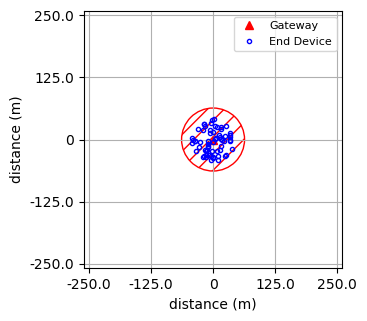

Thresholds for SF7, SF8, SF9, SF10:  [ 0  6 13 19]
Thresholds for SF11, SF12:  [ 0.  4.  8. 12.]


In [15]:
#Initialize env and Q-table
seed=18
n_agents = 64
n_threshold = 4
max_steps = 2000
env = LoRaNetwork(max_steps=max_steps, n_agents=n_agents, n_threshold=n_threshold, loc_range = minDist-20)
env.reset(seed=seed)
plotLocations(env.bsList, env.agents)
print("Thresholds for SF7, SF8, SF9, SF10: ", env.arr_thresholds)
print("Thresholds for SF11, SF12: ", env.arr_thresholds_high)

In [16]:
print("Thresholds for SF11, SF12: ", env.arr_thresholds_high)

Thresholds for SF11, SF12:  [ 0.  4.  8. 12.]


In [17]:
'''[0,0] 0*1+0*3 = 0
[0,1] 0*1+1*3 = 3
[1,0] 1
[1,1] 4
[0,2] 6
[1,2] 7
[2,0] 2
[2,2] 8
[2,1] 5'''

'[0,0] 0*1+0*3 = 0\n[0,1] 0*1+1*3 = 3\n[1,0] 1\n[1,1] 4\n[0,2] 6\n[1,2] 7\n[2,0] 2\n[2,2] 8\n[2,1] 5'

In [18]:
#Training the agent
#Creating lists to keep track of reward and epsilon values
def train_Q():
    
    wandb.init(
    # set the wandb project where this run will be logged
    project="q-lora",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "episodes": train_episodes,
    "max_steps": env._max_steps
    }
)
    epsilon = max_epsilon
    Q = np.ones((env.n_agents, env._n_threshold ** 6, 6))
    training_rewards = []
    epsilons = []
    lrs = []
    pdrs = []
    avg_toa = []
    visited_states = np.zeros(env._n_threshold ** 6)

    for episode in range(train_episodes):
        #Reseting the environment each time as per requirement
        state = env.reset(seed=seed)
        state_idx = get_state_idx(state)
        visited_states[state_idx] = 1
        action_count = np.zeros(6)
        #Starting the tracker for the rewards
        total_training_rewards = 0
        #lr = step_decay(episode, initial_lr)
        exp_exp_tradeoff = np.random.uniform(0, 1, size=[max_steps, env.n_agents])
        for step in range(max_steps):
            #Choosing an action given the states based on a random number
            #exp_exp_tradeoff = np.random.uniform(0, 1, size = n_agents)
            idx = np.argwhere(exp_exp_tradeoff[step] > epsilon)
            action = env.action_space.sample()
            #print("action sampled ", action)
            #print("non-random idx", idx)
            ### STEP 2: SECOND option for choosing the initial action - exploit
            #If the random number is larger than epsilon: employing exploitation
            #and selecting best action
            action[idx] = Q[idx, state_idx, :].argmax(-1)
            #print("Final actions  ", action)
            action_count += np.bincount(action, minlength=6)

            ### STEPs 3 & 4: performing the action and getting the reward
            #Taking the action and getting the reward and outcome state
            new_state, reward, done, info = env.step(action)
            new_state_idx = get_state_idx(new_state)
            #print("New state: ", new_state, new_state_idx)
            ### STEP 5: update the Q-table
            #Updating the Q-table using the Bellman equation
            for i in range(env.n_agents):
                Q[i, state_idx, action[i]] = Q[i, state_idx, action[i]] + lr * (
                            reward + discount_factor * np.max(Q[i, new_state_idx, :]) - Q[i, state_idx, action[i]])
            #Increasing our total reward and updating the state
            total_training_rewards += reward
            state = new_state
            state_idx = new_state_idx
            visited_states[state_idx] = 1

        print(
            "[eps={:.3f}, lr={:.4f} {}, vs={:.2f}%, action_count = {}, avg_pdr = {:.2f}] Total reward for episode {}: {:.3f} | Avg reward per step: {:.3f}".format(
                epsilon, lr, state, 100 * visited_states.mean(), action_count / action_count.sum() * 100, info['pdr'],
                episode, total_training_rewards, total_training_rewards / max_steps))
        wandb.log({"eps": epsilon, "visited_states": 100 * visited_states.mean(), "action_count": np.array(action_count), "pdr":info['pdr'], "toa": info['avg_airtime']})
        #Cutting down on exploration by reducing the epsilon
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)

        #Adding the total reward and reduced epsilon values
        pdrs.append(info['pdr'])
        avg_toa.append(info['avg_airtime'])
        training_rewards.append(total_training_rewards)
        epsilons.append(epsilon)
        lrs.append(lr)

    print("Training score over time: " + str(sum(training_rewards) / train_episodes))
    filename = path + folder + "/q_table_" + "n" + str(env.n_agents) + "_t" + str(env._n_threshold)
    np.save(filename, Q)
    filename = path + folder + "/pdr_" + "n" + str(env.n_agents) + "_t" + str(env._n_threshold)
    np.save(filename, pdrs)
    filename = path + folder + "/airtime_" + "n" + str(env.n_agents) + "_t" + str(env._n_threshold)
    np.save(filename, avg_toa)
    filename = path + folder + "/rewards_" + "n" + str(env.n_agents) + "_t" + str(env._n_threshold)
    np.save(filename, training_rewards)
    eps = epsilons
    lrates = lrs

In [ ]:
train_episodes = 4000
max_steps= 5000
for n in [128]:
  for t in [4,6]:
    env = LoRaNetwork(max_steps=max_steps, n_agents=n, n_threshold=t, loc_range = minDist)
    env.reset(seed=seed)
    print("Thresholds for SF7, SF8, SF9, SF10: ", env.arr_thresholds)
    print("Thresholds for SF11, SF12: ", env.arr_thresholds_high)
    train_Q()

Thresholds for SF7, SF8, SF9, SF10:  [ 0  3  6 10]
Thresholds for SF11, SF12:  [0. 2. 4. 6.]


wandb: Currently logged in as: antonio-s. Use `wandb login --relogin` to force relogin


[eps=1.000, lr=0.0100 [2 1 1 1 1 3], vs=17.58%, action_count = [16.6625  16.68625 16.625   16.71875 16.53875 16.76875], avg_pdr = 0.52] Total reward for episode 0: 2765.699 | Avg reward per step: 0.553
[eps=1.000, lr=0.0100 [2 0 1 1 3 3], vs=22.92%, action_count = [16.643125 16.834375 16.5975   16.6775   16.665625 16.581875], avg_pdr = 0.58] Total reward for episode 1: 2784.067 | Avg reward per step: 0.557
[eps=1.000, lr=0.0100 [0 2 1 2 3 1], vs=25.98%, action_count = [16.82875  16.625    16.515625 16.66125  16.86625  16.503125], avg_pdr = 0.58] Total reward for episode 2: 2772.428 | Avg reward per step: 0.554
[eps=0.999, lr=0.0100 [2 1 2 2 2 0], vs=28.37%, action_count = [16.694375 16.6775   16.7375   16.675    16.69625  16.519375], avg_pdr = 0.74] Total reward for episode 3: 2776.033 | Avg reward per step: 0.555
[eps=0.999, lr=0.0100 [0 2 2 1 3 3], vs=29.76%, action_count = [16.66375  16.654375 16.70125  16.843125 16.535    16.6025  ], avg_pdr = 0.61] Total reward for episode 4: 2782

### Plots Generation

In [140]:
folder="test7"
max_steps = 1000
n_agents = 32
n_threshold= 4
seed_r = range(20)
env = LoRaNetwork(max_steps=max_steps, n_agents=n_agents, n_threshold=n_threshold, loc_range = minDist)
Q = np.load(path+folder+"/q_table_n"+str(env.n_agents)+"_t"+str(env._n_threshold)+".npy")

In [23]:
training_rewards=np.load(path+folder+"/rewards_n"+str(env.n_agents)+"_t"+str(env._n_threshold)+".npy")

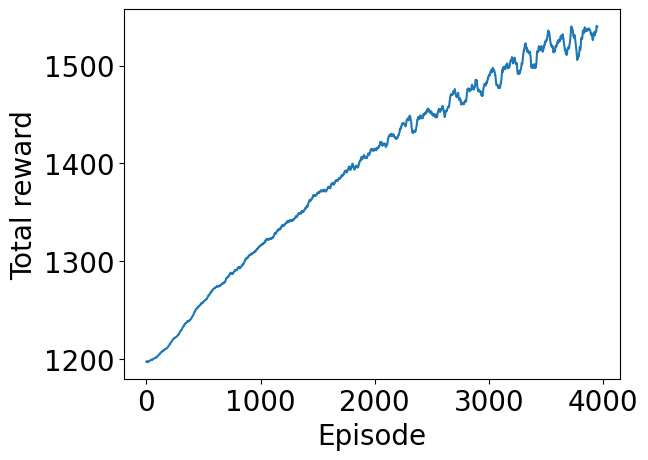

In [24]:
ma = []
window = 50
for i in range(len(training_rewards)-window):
  ma.append(sum(training_rewards[i:i+window])/window)
x = range(len(ma))
plt.plot(x, ma)
plt.xlabel('Episode')
plt.ylabel('Total reward')
#plt.title('N = ' + str(n_agents))
plt.show()

In [141]:
#SF12
del_f = []
pdr = []
for s in seed_r:
  state = env.reset(seed=s)
  action = env.n_agents*[5]
  for step in range(max_steps):
    state, reward, done, info = env.step(action)
    #print("Step {}, action = {}, reward = {}, new state = {}".format(step,action,reward,state))
  #env.render()
  pdr.append(info['pdr'])
  del_f.append(info['del_factor'])
pdr_SF12 = sum(pdr)/len(pdr)
delf_SF12 = sum(del_f)/len(del_f)
print(pdr_SF12)

0.0078125


In [142]:
#SF7
del_f = []
pdr = []
for s in seed_r:
  state = env.reset(seed=s)
  action = env.n_agents*[0]
  for step in range(max_steps):
    state, reward, done, info = env.step(action)
    #print("Step {}, action = {}, reward = {}, new state = {}".format(step,action,reward,state))
  #env.render()
    pdr.append(info['pdr'])
    del_f.append(info['del_factor'])
pdr_SF7 = sum(pdr)/len(pdr)
delf_SF7 = sum(del_f)/len(del_f)
print(pdr_SF7)
print(delf_SF7)

0.6308751615386322
0.006468126246091322


In [143]:
#Random
pdr = []
toa = []
del_f = []
for s in seed_r:
  state = env.reset(seed=s)
  for step in range(max_steps):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    #print("Step {}, action = {}, reward = {}, new state = {}".format(step,action,reward,state))
  #env.render()
    pdr.append(info['pdr'])
    toa.append(info['avg_airtime'])
    del_f.append(info['del_factor'])
pdr_random = sum(pdr)/len(pdr)
avg_toa_random = sum(toa)/len(toa)
delf_random = sum(del_f)/len(del_f)
print(pdr_random)
print(avg_toa_random)
print(delf_random)

0.635156906202009
806.0811558959416
0.0008259374491161694


In [144]:
#Smart
pdr = []
toa = []
del_f = []
n_use = np.zeros(6)
#seed_r = [18]
for s in seed_r:
  state = env.reset(seed=s)
  for step in range(max_steps):
    state_idx = get_state_idx(state)
    action = Q[:,state_idx,:].argmax(-1)
    n_use += np.bincount(action, minlength=6)
    #%lprun  -f env.transmit  state, reward, _, _ = env.step(action)
    state, reward, done, info = env.step(action)
    #print("Step {}, action = {}, reward = {}, new state = {}".format(step,action,reward,state))
  #env.render()
    pdr.append(info['pdr'])
    toa.append(info['avg_airtime'])
    del_f.append(info['del_factor'])
pdr_smart = sum(pdr)/len(pdr)
avg_toa_smart = sum(toa)/len(toa)
delf_smart = sum(del_f)/len(del_f)
print(pdr_smart)
print(avg_toa_smart)
print(delf_smart)
print(n_use)
print(n_use.sum())

0.7763102226018468
452.9583953927841
0.001759862506127405
[180251. 153056. 109001. 100879.  76215.  20598.]
640000.0


In [109]:
#Smart
pdr = []
toa = []
del_f = []
pdr_seed_list = []
toa_seed_list = []

n_use = np.zeros(6)
#seed_r = [18]
for s in seed_r:
    state = env.reset(seed=s)
    for step in range(max_steps):
        state_idx = get_state_idx(state)
        action = Q[:,state_idx,:].argmax(-1)
        n_use += np.bincount(action, minlength=6)
        #%lprun  -f env.transmit  state, reward, _, _ = env.step(action)
        state, reward, done, info = env.step(action)
        #print("Step {}, action = {}, reward = {}, new state = {}".format(step,action,reward,state))
      #env.render()
        pdr.append(info['pdr'])
        toa.append(info['avg_airtime'])
        del_f.append(info['del_factor'])
    pdr_seed = sum(pdr)/len(pdr)
    pdr_seed_list.append(pdr_seed)
    avg_toa_seed = sum(toa)/len(toa)
    toa_seed_list.append(avg_toa_seed)
pdr_smart = sum(pdr)/len(pdr)
avg_toa_smart = sum(toa)/len(toa)
delf_smart = sum(del_f)/len(del_f)
print(pdr_smart)
print(avg_toa_smart)
print(delf_smart)
print(n_use)
print(n_use.sum())

0.7767804936205701
452.9583953927841
0.0017607128542310054
[180251. 153056. 109001. 100879.  76215.  20598.]
640000.0


In [131]:
import scipy.stats as st
print(f"Escursione PDR: {max(pdr_seed_list) - min(pdr_seed_list)}")
a = np.array(pdr_seed_list)
b = np.array(toa_seed_list)
print(f"Media PDR: {a.mean()}")
print(f"Std PDR: {a.std()}")
print(f"Escursione ToA: {max(toa_seed_list) - min(toa_seed_list)}")
print(f"Media ToA: {b.mean()}")
print(st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a)))
print(st.t.interval(0.95, len(b)-1, loc=np.mean(b), scale=st.sem(b)))

Escursione PDR: 0.0016177295760722021
Media PDR: 0.7766136281080626
Std PDR: 0.00037234597090532164
Escursione ToA: 7.406678453565348
Media ToA: 452.9885607129081
(0.7764348377567006, 0.7767924184594245)
(452.2813984684542, 453.695722957362)


In [105]:
pdr_t4 = 0.8600000000000001
pdr_t6 = 0.8554166666666667
pdr_t8 = 0.7586904761904762
avg_toa_t4 = 669.4016503068297
avg_toa_t6 = 370.65825160389767
avg_toa_t8 = 141.887454826176
#128
pdr_adr = 0.18456529919861647
avg_toa_adr = 1678.6192199882798
delf_adr = 0.00014239299917334858
#64
pdr_adr = 0.39402070873959727
avg_toa_adr= 977.5077745604827
delf_adr = 0.001249376588786288
#32
pdr_adr = 0.5974700197309306
avg_toa_adr= 633.404380396498
delf_adr = 0.0026266493013397526

[0.8600000000000001, 0.8554166666666667, 0.7586904761904762]


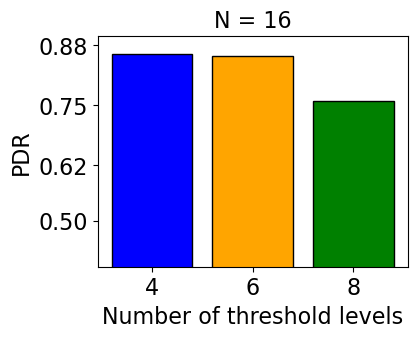

In [85]:
pdr_plot_val = [pdr_t4, pdr_t6, pdr_t8]
#pdr_plot_val = [0.8600000000000001, 0.8554166666666667, 0.7586904761904762]
print(pdr_plot_val)
y = np.arange(3)
plt.figure(figsize=(4,3))
plt.xlabel("Number of threshold levels",fontsize=16)
xticks=['4', '6', '8']
plt.xticks(y, xticks, fontsize=16)
plt.yticks(np.round(np.linspace(0.5, 1.0, num=5),2),fontsize=16)
plt.ylim(bottom=0.4, top=0.9)
plt.ylabel("PDR",fontsize=16)
plt.title("N = 16",fontsize=16)
#plt.subplots_adjust(bottom=0.15, left=0.15)
#plt.subplots_adjust(top=0.85)
plt.bar(y, pdr_plot_val, color = ['blue', 'orange', 'green', 'purple'], edgecolor='black')
plt.savefig("t_pdr_"+str(n_agents)+".pdf", bbox_inches='tight')

[0.7951454477844894, 0.8244422213255993, 0.7536606344062831]


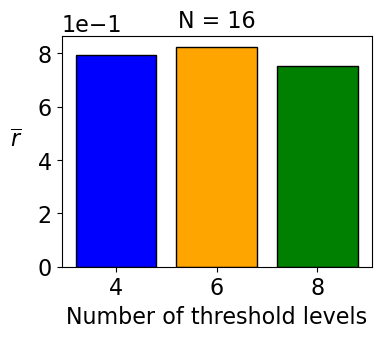

In [74]:
r_t4 = pdr_t4 - env.beta*(avg_toa_t4 - env.min_air_time)/(env.max_air_time-env.min_air_time)
r_t6 = pdr_t6 - env.beta*(avg_toa_t6 - env.min_air_time)/(env.max_air_time-env.min_air_time)
r_t8 = pdr_t8 - env.beta*(avg_toa_t8 - env.min_air_time)/(env.max_air_time-env.min_air_time)
delf_plot_val = [r_t4, r_t6, r_t8]
#delf_plot_val = [0.0014866386491753341, 0.00518572875307218, 0.007778568694538179]
print(delf_plot_val)
y = np.arange(3)
plt.figure(figsize=(4,3))
plt.xlabel("Number of threshold levels")
xticks=['4', '6', '8']
plt.xticks(y, xticks, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$\overline{r}$',fontsize=16,rotation=0,ha='left',labelpad=20)
plt.title("N = 16",fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits = (0,0))
#plt.subplots_adjust(bottom=0.15, left=0.15)
#plt.subplots_adjust(top=0.85)
plt.bar(y, delf_plot_val, color = ['blue', 'orange', 'green', 'purple'], edgecolor='black')
#plt.ylim([r_t8/2, r_t6+r_t6/4])
plt.savefig("t_delf_"+str(n_agents)+".pdf", bbox_inches='tight')

In [ ]:
toa_plot_val = [toa_t4, toa_t6, toa_t8]
#toa_plot_val = [669.4016503068297, 370.65825160389767, 141.887454826176]
print(toa_plot_val)
y = np.arange(3)
plt.figure(figsize=(4,3))
plt.xlabel("Number of threshold levels",fontsize=16)
xticks=['4', '6', '8']
plt.xticks(y, xticks, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("ToA (ms)",fontsize=16)
plt.title("N = "+str(n_agents),fontsize=16)
#plt.subplots_adjust(bottom=0.15, left=0.15)
#plt.subplots_adjust(top=0.85)
plt.bar(y, toa_plot_val, color = ['blue', 'orange', 'green', 'purple'], edgecolor='black')
plt.savefig("t_toa_"+str(n_agents)+".pdf", bbox_inches='tight')

[125.95039999999999, 210.41609572575356]


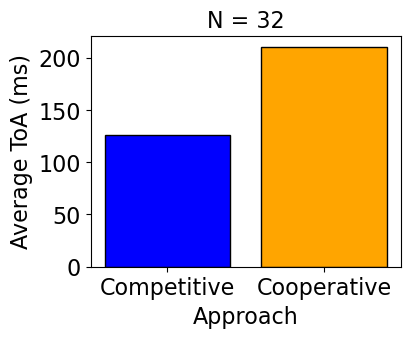

In [164]:
#avg_toa_comp=141
avg_toa_comp = 125.95039999999999
avg_toa_smart = 210.41609572575356

toa_plot_val = [avg_toa_comp, avg_toa_smart]
#toa_plot_val = [141, 562.8569414611039]
print(toa_plot_val)
y = np.arange(2)
plt.figure(figsize=(4,3))
plt.xlabel("Approach")
xticks=['Competitive', 'Cooperative']
plt.xticks(y, xticks, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Average ToA (ms)",fontsize=16)
plt.title("N = "+str(n_agents),fontsize=16)
#plt.subplots_adjust(bottom=0.15, left=0.15)
#plt.subplots_adjust(top=0.85)
plt.bar(y, toa_plot_val, color = ['blue', 'orange', 'green', 'purple'], edgecolor='black')
plt.savefig("toa_comp"+str(n_agents)+".pdf", bbox_inches='tight')

[0.9253105638800664, 0.9706500000000017]


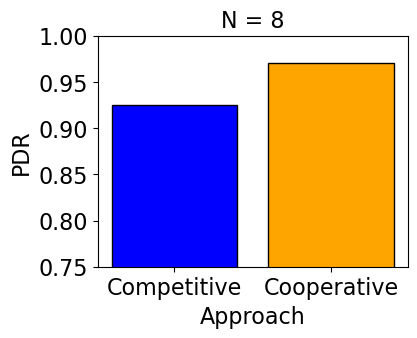

In [163]:
#pdr_comp=0.872874337102896
pdr_comp=0.9253105638800664
pdr_smart = 0.9706500000000017
pdr_plot_val = [pdr_comp, pdr_smart]
print(pdr_plot_val)
y = np.arange(2)
plt.figure(figsize=(4,3))
plt.xlabel("Approach")
xticks=['Competitive', 'Cooperative']
plt.xticks(y, xticks, fontsize=16)
plt.yticks([0.75,0.80,0.85,0.90,0.95, 1], fontsize=16)
plt.ylabel("PDR",fontsize=16)
plt.title("N = 8",fontsize=16)
plt.ylim(bottom=0.75, top=1)
#plt.subplots_adjust(bottom=0.15, left=0.15)
#plt.subplots_adjust(top=0.85)
plt.bar(y, pdr_plot_val, color = ['blue', 'orange', 'green', 'purple'], edgecolor='black')
plt.savefig("comp_pdr_"+str(n_agents)+".pdf", bbox_inches='tight')

[0.922088123106637, 0.9578484126719119]


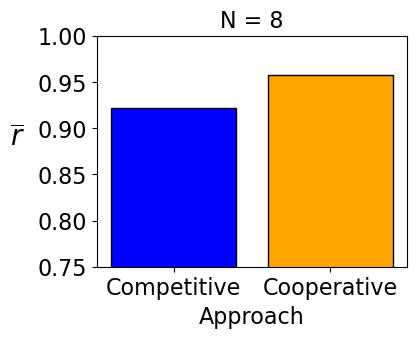

In [171]:
#delf_comp=0.005845630698370893
r_comp = pdr_comp - env.beta*(avg_toa_comp - env.min_air_time)/(env.max_air_time-env.min_air_time)
r_smart = pdr_smart - env.beta*(avg_toa_smart - env.min_air_time)/(env.max_air_time-env.min_air_time)
delf_plot_val = [r_comp, r_smart]
print(delf_plot_val)
y = np.arange(2)
plt.figure(figsize = (4, 3))
plt.xlabel("Approach",fontsize=16)
xticks=['Competitive', 'Cooperative']
plt.xticks(y, xticks, fontsize=16)
plt.yticks([0.75,0.80,0.85,0.90,0.95, 1],fontsize=16)
plt.ylabel(r'$\overline{r}$',fontsize=20,rotation=0,ha='left',labelpad=20)
plt.title("N = 8", fontsize=16)
plt.ylim(bottom=0.75)
plt.bar(y, delf_plot_val, color = ['blue', 'orange', 'green', 'purple'], edgecolor='black')
plt.savefig("rcomp_"+str(n_agents)+".pdf", bbox_inches='tight')

In [ ]:
delf_comp=0.005845630698370893
delf_plot_val = [delf_comp, delf_smart]
#print(pdr_plot_val)
y = np.arange(2)
plt.figure(figsize = (4, 3))
plt.xlabel("Approach",fontsize=16)
xticks=['Competitive', 'Cooperative']
plt.xticks(y, xticks, fontsize=16)
plt.yticks(fontsize=10)
plt.ylabel(r'$\overline{r}$',fontsize=20,rotation=0,ha='left',labelpad=20)
plt.title("N = "+str(n_agents), fontsize=16)
#plt.subplots_adjust(bottom=0.15, left=0.15)
#plt.subplots_adjust(top=0.85)
plt.bar(y, delf_plot_val, color = ['blue', 'orange', 'green', 'purple'], edgecolor='black')
plt.savefig("delfcomp_"+str(n_agents)+".pdf", bbox_inches='tight')

[0.18654577310613435, 0.31931838790126005, 0.3982382110314692, 0.5974700197309306, 0.0007936507936507937]


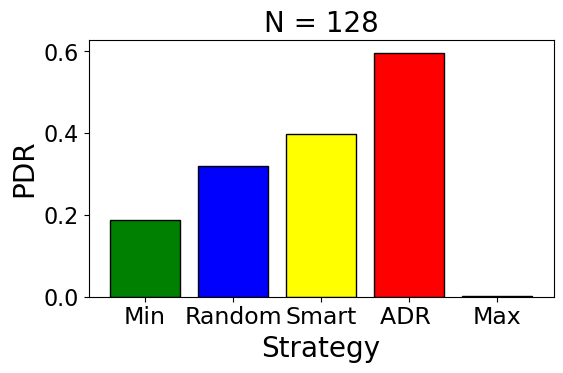

In [137]:
pdr_plot_val = [pdr_SF7, pdr_random, pdr_smart, pdr_adr, pdr_SF12]
#pdr_plot_val.extend(avg_pdrs[-1])
print(pdr_plot_val)
y = np.arange(5)
xticks= ['Min','Random','Smart', 'ADR ', 'Max']
plt.figure(figsize=(6, 3.33))
plt.xlabel("Strategy",fontsize=20)
plt.ylabel("PDR",fontsize=20)
plt.xticks(y,xticks, fontsize=17)
plt.title("N = "+str(n_agents), fontsize=20)
#plt.subplots_adjust(bottom=0.15, left=0.15)
#plt.subplots_adjust(top=0.85)
plt.bar(y, pdr_plot_val, color = ['green', 'blue', 'yellow','red', 'purple'], edgecolor='black')
plt.savefig("pdr_"+str(n_agents)+".pdf", bbox_inches='tight')

In [ ]:
(avg_toa_smart-env.min_air_time)/(env.max_air_time-env.min_air_time)

[97.536, 805.0145523444611, 518.1264531819276, 633.404380396498, 2301.952]


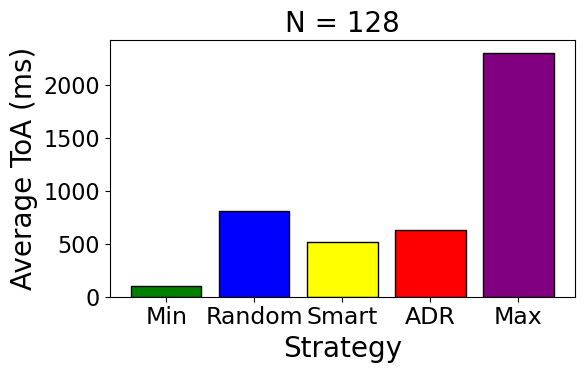

In [138]:
toa_plot_val = [env.min_air_time, avg_toa_random, avg_toa_smart, avg_toa_adr, env.max_air_time]
#pdr_plot_val.extend(avg_pdrs[-1])
print(toa_plot_val)
y = np.arange(5)
xticks= ['Min','Random','Smart', 'ADR', 'Max']
plt.figure(figsize=(6, 3.33))
plt.xlabel("Strategy", fontsize=20)
plt.ylabel("Average ToA (ms)", fontsize=20)
plt.xticks(y,xticks,fontsize=17)
plt.title("N = "+str(n_agents),fontsize=20)
#plt.subplots_adjust(bottom=0.15, left=0.15)
#plt.subplots_adjust(top=0.85)
plt.bar(y, toa_plot_val, color = ['green', 'blue', 'yellow','red', 'purple'], edgecolor='black')
plt.savefig("toa_"+str(n_agents)+".pdf", bbox_inches='tight')

0.025118864315095794
[11.285136182543184, 6.3414175354989775, 8.867661325550973]


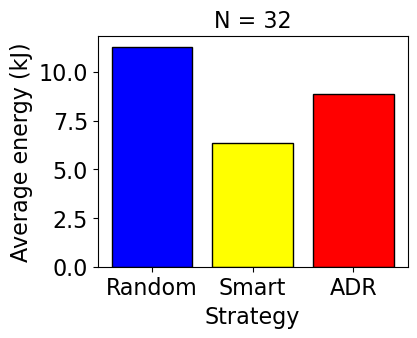

In [145]:
Ptx_abs = 10**((Ptx)/10.)/1000
print(Ptx_abs)
E_avg_random = Ptx*avg_toa_random
E_avg_smart = Ptx*avg_toa_smart
E_avg_adr = Ptx*avg_toa_adr
toa_plot_val = [E_avg_random/max_steps, E_avg_smart/max_steps, E_avg_adr/max_steps]
#toa_plot_val = [11.262131957465266, 2.9664106335972362]
#pdr_plot_val.extend(avg_pdrs[-1])
print(toa_plot_val)
y = np.arange(3)
xticks= ['Random','Smart', 'ADR']
plt.figure(figsize=(4, 3))
plt.xlabel("Strategy",fontsize=16)
plt.ylabel("Average energy (kJ)",fontsize=16)
plt.xticks(y,xticks,fontsize=16)
plt.yticks(fontsize=16)
plt.title("N = "+str(n_agents),fontsize=16)
#plt.subplots_adjust(bottom=0.15, left=0.15)
#plt.subplots_adjust(top=0.85)
plt.bar(y, toa_plot_val, color = ['blue', 'yellow', 'red'], edgecolor='black')
plt.savefig("ptx_"+str(n_agents)+".pdf", bbox_inches='tight')

In [ ]:
env.loc_range

In [ ]:
(1 - toa_plot_val[1]/toa_plot_val[0])

[0.004201427338226, 0.0006041393311531754, 0.0008082268156896423, 2.397423230460414e-06]


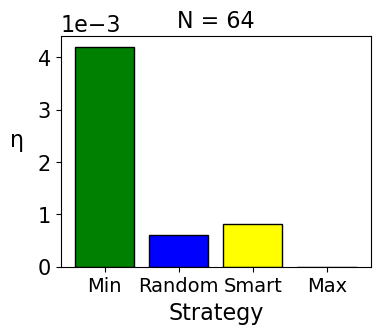

In [41]:
delfs = [delf_SF7, delf_random, delf_smart, delf_SF12]
#pdr_plot_val.extend(avg_pdrs[-1])
print(delfs)
y = np.arange(4)
xticks= ['Min','Random','Smart', 'Max']
plt.rc('font', **{'size':'16'})
plt.figure(figsize=(4,3))
plt.xlabel("Strategy",fontsize=16)
plt.ylabel("η",fontsize=16,rotation=0,ha='left',labelpad=20)
plt.xticks(y,xticks,fontsize=14)
plt.yticks(fontsize=15)
plt.ticklabel_format(axis='y', style='sci', scilimits = (0,0))
plt.title("N = "+str(n_agents),fontsize=16)
#plt.subplots_adjust(bottom=0.15, left=0.15)
#plt.subplots_adjust(top=0.85)
plt.bar(y, delfs, color = ['green', 'blue', 'yellow','red'], edgecolor='black')
plt.savefig("eta_"+str(n_agents)+".pdf", bbox_inches='tight')

In [ ]:
avg_toa = np.load(path+folder+"/airtime_n"+str(n_agents)+"_t4.npy")

[0.6311571979944826, 0.5560340581282963, 0.7371303725646607, 0.5366978718699441]


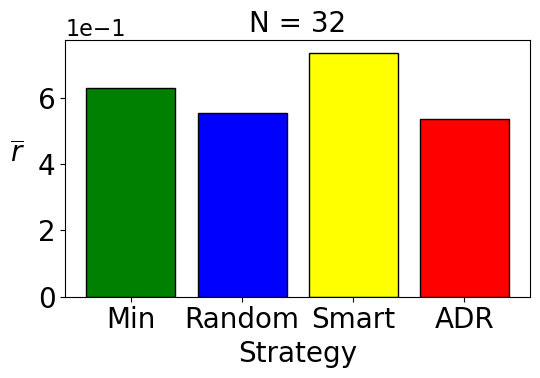

In [108]:
#TEST
r_SF7 = pdr_SF7
r_SF12= pdr_SF12 - env.beta
r_smart = pdr_smart-env.beta*(avg_toa_smart-env.min_air_time)/(env.max_air_time-env.min_air_time)
r_random =  pdr_random-env.beta*(avg_toa_random-env.min_air_time)/(env.max_air_time-env.min_air_time)
r_adr =  pdr_adr-env.beta*(avg_toa_adr-env.min_air_time)/(env.max_air_time-env.min_air_time)
delfs = [r_SF7, r_random, r_smart, r_adr]
#delfs= [0.898184821428575, 0.7986428294668132, 0.957404365052864]
#pdr_plot_val.extend(avg_pdrs[-1])
print(delfs)
y = np.arange(4)
xticks= ['Min','Random','Smart', 'ADR']
plt.rc('font', **{'size':'16'})
plt.figure(figsize=(6, 3.33))
plt.xlabel("Strategy",fontsize=20)
plt.ylabel(r'$\overline{r}$',fontsize=20,rotation=0,ha='left',labelpad=20)
plt.xticks(y,xticks,fontsize=20)
plt.yticks(fontsize=20)
plt.ticklabel_format(axis='y', style='sci', scilimits = (0,0))
plt.title("N = "+str(n_agents),fontsize=20)
#plt.subplots_adjust(bottom=0.15, left=0.15)
#plt.subplots_adjust(top=0.85)
plt.bar(y, delfs, color = ['green', 'blue', 'yellow', 'red'], edgecolor='black')
plt.savefig("eff_"+str(n_agents)+".pdf", bbox_inches='tight')

In [ ]:
plt.figure()
ma = []
window = 50
for i in range(len(avg_toa)-window):
  ma.append(sum(avg_toa[i:i+window])/window)
x = range(len(ma))
plt.plot(x, ma)
plt.xlabel('Episode')
plt.ylabel('ToA (ms)')
#plt.title('Moving average over all episodes')
plt.axhline(avg_toa_random, color='red')
plt.axhline(env.min_air_time,color = 'green')
plt.subplots_adjust(bottom=0.15, left=0.35)
plt.savefig('toa test')
plt.show()

In [ ]:
pdr = np.load(path+folder+"/pdr_n"+str(n_agents)+"_t4.npy")

In [ ]:
plt.figure()
ma = []
window = 100
for i in range(len(pdr)-window):
  ma.append(sum(pdr[i:i+window])/window)
x = range(len(ma))
plt.plot(x, ma)
plt.xlabel('Episode')
plt.ylabel('PDR')
#plt.title('Moving average over all episodes')
plt.axhline(pdr_random, color='red')
#plt.axhline(env.min_air_time,color = 'green')
plt.subplots_adjust(bottom=0.15, left=0.35)
plt.savefig('toa test')
plt.show()

In [ ]:
#Visualizing results and total reward over all episodes
#x = range(train_episodes)
plt.plot(training_rewards)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.title('Total rewards over all episodes')
plt.show()

In [ ]:
epsilons = []
lrs = []
for episode in range(train_episodes):
  lr = step_decay(episode, initial_lr)
  epsilon = min_epsilon + (max_epsilon - min_epsilon)*math.exp(-decay*episode)
  lrs.append(lr)
  epsilons.append(epsilon)

In [ ]:
#Visualizing the epsilons over all episodes
plt.figure(figsize=(4,3))
plt.xlabel('Episode',fontsize=16)
plt.ylabel('Epsilon',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([1, 0.8,0.6,0.4,0.2,0],fontsize=16)
plt.plot(epsilons)
#plt.title("Epsilon for episode")
plt.savefig("eps.pdf", bbox_inches='tight')
plt.show()

In [ ]:
#Visualizing the PDR over all episodes
plt.plot(pdrs)
plt.xlabel('Episode')
plt.ylabel('PDR')
plt.show()

In [ ]:
#Visualizing the PDR over all episodes
plt.plot(avg_toa)
plt.xlabel('Episode')
plt.ylabel('Average ToA')
plt.show()

In [ ]:
#Visualizing the epsilons over all episodes
plt.figure(figsize=(4,3))
plt.xlabel('Episode',fontsize=16)
plt.ylabel('Learning rate',fontsize=16)
plt.locator_params(axis='y', nbins=5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(lrs)
#plt.title("Epsilon for episode")
plt.savefig("lrs.pdf", bbox_inches='tight')
plt.show()

In [ ]:
print(env.max_air_time)
print(env.min_air_time)

[31.9946875  20.3078125  14.84359375 16.37945312  7.85539063  8.6190625 ]


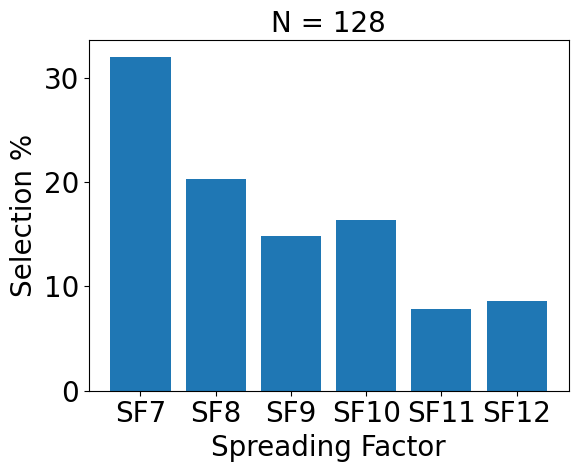

In [47]:
action_count=n_use
y = np.arange(6)
print(action_count/action_count.sum()*100)
sf = ['SF7','SF8','SF9','SF10','SF11','SF12']
plt.figure()
plt.subplots_adjust(bottom=0.15, left=0.15)
plt.bar(y, action_count/action_count.sum()*100)
plt.xticks(y,sf)
plt.title("N = "+str(n_agents),fontsize=20)
plt.xlabel("Spreading Factor")
plt.ylabel("Selection %")
plt.savefig("selection.pdf", bbox_inches='tight')